In [175]:
import re
import string
from pathlib import Path
from typing import Dict, Any, Union

import joblib
import numpy
from matplotlib import pyplot as plt
from numpy import asarray, average, dtype, ndarray
from pandas import read_csv, DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import roc_curve, balanced_accuracy_score, auc, precision_score, recall_score, f1_score, \
    classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm.contrib.itertools import product


In [16]:
# Constant Numbers
CV = 5
OVERWRITE = True
RANDOM_STATE = 42
TEST_SIZE = 2e-1

# Paths
GLOVE_6B_50D_TXT = Path('models/glove.6B/glove.6B.50d.txt')
GLOVE_6B_100D_TXT = Path('models/glove.6B/glove.6B.100d.txt')
GLOVE_6B_200D_TXT = Path('models/glove.6B/glove.6B.200d.txt')
GLOVE_6B_300D_TXT = Path('models/glove.6B/glove.6B.300d.txt')
GLOVE_42B_300D_TXT = Path('models/glove.42B/glove.42B.300d.txt')
GLOVE_840B_300D_TXT = Path('models/glove.840B/glove.840B.300d.txt')
GLOVE_TWITTER_27B_25D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.25d.txt')
GLOVE_TWITTER_27B_50D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.50d.txt')
GLOVE_TWITTER_27B_100D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.100d.txt')
GLOVE_TWITTER_27B_200D_TXT = Path('models/glove.twitter.27B/glove.twitter.27B.200d.txt')

MODELS_DICT_PKL = Path('models/old/models_dict.pkl')
OPTIMAL_MODEL_PKL = Path('models/old/optimal_model.pkl')

THREAT_TWEETS_JSON = Path('data/threat.tweets.json')

ANASTASIA_CSV = Path('data/anastasia.csv')
THREAT_TWEETS_CSV = Path('data/threat.tweets.csv')


In [17]:
MODELS_INFO = [
    {'name': 'GloVe.6B.50D', 'model-path': GLOVE_6B_50D_TXT, 'embedding-dim': 50},
    {'name': 'GloVe.6B.100D', 'model-path': GLOVE_6B_100D_TXT, 'embedding-dim': 100},
    {'name': 'GloVe.6B.200D', 'model-path': GLOVE_6B_200D_TXT, 'embedding-dim': 200},
    {'name': 'GloVe.6B.300D', 'model-path': GLOVE_6B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.42B.300D', 'model-path': GLOVE_42B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.840B.300D', 'model-path': GLOVE_840B_300D_TXT, 'embedding-dim': 300},
    #{'name': 'GloVe.Twitter.27B.25D', 'model-path': GLOVE_TWITTER_27B_25D_TXT, 'embedding-dim': 25},
    #{'name': 'GloVe.Twitter.27B.50D', 'model-path': GLOVE_TWITTER_27B_50D_TXT, 'embedding-dim': 50},
    #{'name': 'GloVe.Twitter.27B.100D', 'model-path': GLOVE_TWITTER_27B_100D_TXT, 'embedding-dim': 100},
    #{'name': 'GloVe.Twitter.27B.200D', 'model-path': GLOVE_TWITTER_27B_200D_TXT, 'embedding-dim': 200}
]


In [18]:
def load_word2vec_dict(model_path: Path, embedding_dim: int) -> dict[Union[str, list[str]], ndarray[Any, dtype]]:
    embeddings_dict = {}

    f = open(model_path, 'r', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = ' '.join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()

    return embeddings_dict


In [19]:
def preprocess_texts(list_str, model_path, embedding_dim):
    word2vec_dict = load_word2vec_dict(
        model_path=model_path,
        embedding_dim=embedding_dim
    )
    list_embedded_str = numpy.zeros((len(list_str), embedding_dim))
    for i, text in enumerate(list_str):
        tokens = re.findall(r'\w+|[{}]'.format(re.escape(string.punctuation)), text)
        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue
    return list_embedded_str


In [46]:
def train_classifier(
        x: ndarray, y: ndarray, cv: int = 1, random_state: int = None, test_size: float = 0.2, model_type: str = None
) -> Dict[str, Union[float, Any]]:
    classifier_dict = {
        'cv-accuracy': 0,
        'model': None
    }

    if model_type == 'nb':
        classifier = GaussianNB()
    elif model_type == 'svm':
        classifier = SVC()
    elif model_type == 'rf':
        classifier = RandomForestClassifier(
            n_estimators=151,
            max_depth=15,
            min_samples_split=21,
            min_samples_leaf=10,
            bootstrap=False,
            random_state=RANDOM_STATE,
            verbose=0
        )
    elif model_type == 'mlp':
        classifier = MLPClassifier()
    elif model_type == 'dt':
        classifier = DecisionTreeClassifier()
    elif model_type == 'gp':
        classifier = GaussianProcessClassifier()
    else:
        return classifier_dict

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y
    )

    classifier_dict['cv-accuracy'] = average(a=cross_val_score(
        estimator=classifier,
        X=x,
        y=y,
        scoring='balanced_accuracy',
        cv=cv
    ))

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    classifier.fit(X=x_train, y=y_train)

    y_predicted_test = classifier.predict(X=x_test)
    y_predicted_train = classifier.predict(X=x_train)
    fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_predicted_train)
    fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_predicted_test)

    classifier_dict['model'] = classifier
    classifier_dict['train'] = {
        'accuracy': balanced_accuracy_score(y_true=y_train, y_pred=y_predicted_train),
        'precision': precision_score(y_true=y_train, y_pred=y_predicted_train),
        'recall': recall_score(y_true=y_train, y_pred=y_predicted_train),
        'f1': f1_score(y_true=y_train, y_pred=y_predicted_train),
        'fpr': fpr_train,
        'tpr': tpr_train,
        'auc': auc(x=fpr_train, y=tpr_train)
    }
    classifier_dict['test'] = {
        'accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_predicted_test),
        'precision': precision_score(y_true=y_test, y_pred=y_predicted_test),
        'recall': recall_score(y_true=y_test, y_pred=y_predicted_test),
        'f1': f1_score(y_true=y_test, y_pred=y_predicted_test),
        'fpr': fpr_test,
        'tpr': tpr_test,
        'auc': auc(x=fpr_test, y=tpr_test)
    }

    return classifier_dict


In [31]:
threat_tweets = read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
threat_tweets.head()


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,[],NaN,NaN
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True


In [32]:
threat_tweets[(threat_tweets['type'] == 'vulnerability') & (threat_tweets['relevant'] == True)].head()


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
6,b'5b88770abb325e65fa7e78e7',2018-08-30 23:00:25+00:00,1035301242271096832,True,(good slides): \n\nThe Advanced Exploitation o...,{'created_at': 'Thu Aug 30 23:00:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://twitter.com/i/web/status/10353012422...,https://twitter.com/i/web/status/1035301242271...,True
7,b'5b887713bb325e65fa7e78e8',2018-08-30 23:00:35+00:00,1035301282095853569,True,CVE-2018-1000532 (beep)\nhttps://t.co/CaKbo38U...,{'created_at': 'Thu Aug 30 23:00:35 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://web.nvd.nist.gov/view/vuln/detail?vu...,https://nvd.nist.gov/vuln/detail/CVE-2018-1000532,True
12,b'5b887816bb325e65fa7e78ed',2018-08-30 23:04:53+00:00,1035302366273257472,True,OpenSSH vulnerability affecting all versions b...,{'created_at': 'Thu Aug 30 23:04:53 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://lnkd.in/fuU3BPk'],https://lnkd.in/fuU3BPk,True
13,b'5b88781dbb325e65fa7e78ee',2018-08-30 23:05:00+00:00,1035302394148601857,True,law in Fiserv banking platform exposed persona...,{'created_at': 'Thu Aug 30 23:05:00 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,['https://hubs.ly/H0dByWm0'],https://www.itpro.com/vulnerability/31797/flaw...,True
25,b'5b887a29bb325e65fa7e78fa',2018-08-30 23:13:45+00:00,1035304594677460992,True,'Insight' into Home Automation Reveals Vulnera...,{'created_at': 'Thu Aug 30 23:13:45 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",threat,"['http://bit.ly/2wyOWAp', 'https://twitter.com...",https://www.mcafee.com:443/blogs/?utm_content=...,True


In [151]:
texts = threat_tweets['text']
target = threat_tweets['relevant']

classifiers = ['nb', 'rf', 'dt', 'svm']

if MODELS_DICT_PKL.exists():
    models_dict = joblib.load(MODELS_DICT_PKL)
else:
    models_dict = {}

for (model_info, classifier) in product(MODELS_INFO, classifiers):
    x = preprocess_texts(
        list_str=texts,
        model_path=model_info['model-path'],
        embedding_dim=model_info['embedding-dim']
    )
    model_name = f"{classifier.upper()} {model_info['name']}"
    model_dict = train_classifier(
        x=x,
        y=target,
        cv=CV,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE,
        model_type=classifier
    )
    model_dict['name'] = model_name
    try:
        if OVERWRITE and model_dict['cv-accuracy'] > models_dict[model_name]['cv-accuracy']:
            models_dict[model_name] = model_dict
    except KeyError:
        models_dict[model_name] = model_dict
    print(f"· {classifier.upper()} {model_info['name']} - CV Accuracy:\t{models_dict[model_name]['cv-accuracy']:.2f}%")


  0%|          | 0/16 [00:00<?, ?it/s]

· NB GloVe.6B.50D - CV Accuracy:	0.69%
· RF GloVe.6B.50D - CV Accuracy:	0.76%
· DT GloVe.6B.50D - CV Accuracy:	0.68%
· SVM GloVe.6B.50D - CV Accuracy:	0.74%
· NB GloVe.6B.100D - CV Accuracy:	0.70%
· RF GloVe.6B.100D - CV Accuracy:	0.75%
· DT GloVe.6B.100D - CV Accuracy:	0.68%
· SVM GloVe.6B.100D - CV Accuracy:	0.75%
· NB GloVe.6B.200D - CV Accuracy:	0.70%
· RF GloVe.6B.200D - CV Accuracy:	0.76%
· DT GloVe.6B.200D - CV Accuracy:	0.67%
· SVM GloVe.6B.200D - CV Accuracy:	0.76%
· NB GloVe.6B.300D - CV Accuracy:	0.70%
· RF GloVe.6B.300D - CV Accuracy:	0.76%
· DT GloVe.6B.300D - CV Accuracy:	0.68%
· SVM GloVe.6B.300D - CV Accuracy:	0.77%


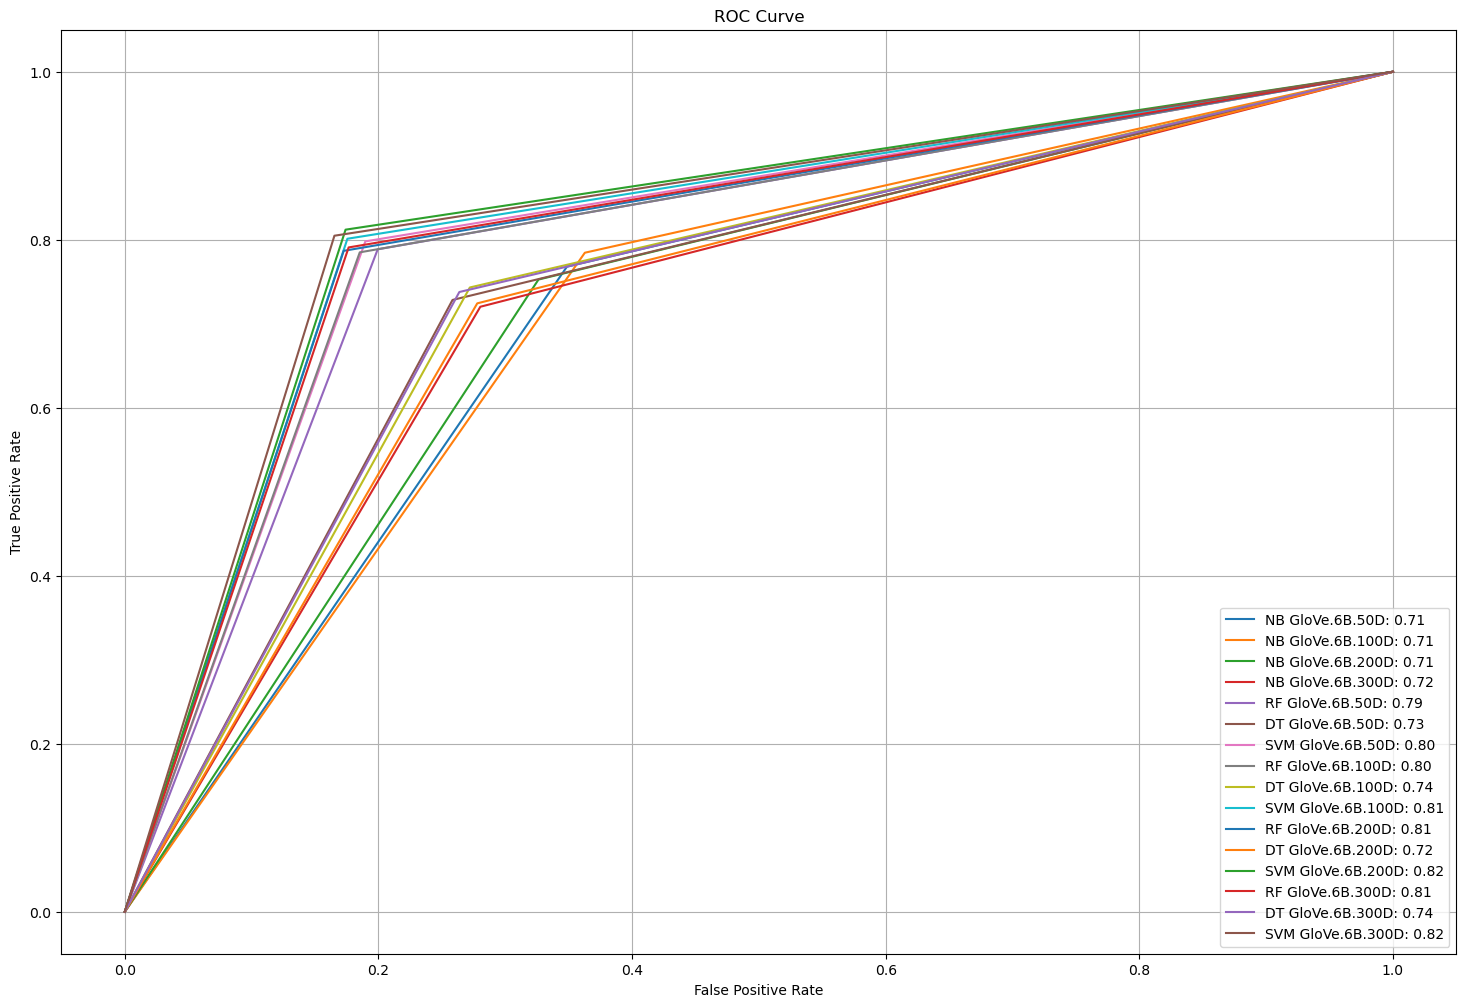

In [152]:
plt.figure(figsize=(18, 12))

for name, model_dict in models_dict.items():
    plt.plot(
        model_dict['test']['fpr'], model_dict['test']['tpr'],
        label=f"{name}: {model_dict['test']['auc']:.2f}"
    )

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [153]:
max_cv_score = 0.
optimal_model = None

for name, model in models_dict.items():
    if models_dict[name]['cv-accuracy'] > max_cv_score:
        max_cv_score = models_dict[name]['cv-accuracy']
        optimal_model = model
        optimal_model['name'] = name

optimal_model


{'cv-accuracy': 0.7688885948967015,
 'model': SVC(),
 'train': {'accuracy': 0.8654685874927477,
  'precision': 0.8768737841858336,
  'recall': 0.8620767240409495,
  'f1': 0.8694122986158385,
  'fpr': array([0.        , 0.13113955, 1.        ]),
  'tpr': array([0.        , 0.86207672, 1.        ]),
  'auc': 0.8654685874927477},
 'test': {'accuracy': 0.8197415521827234,
  'precision': 0.8406954887218046,
  'recall': 0.8047683310841206,
  'f1': 0.8223396920248219,
  'fpr': array([0.        , 0.16528523, 1.        ]),
  'tpr': array([0.        , 0.80476833, 1.        ]),
  'auc': 0.8197415521827235},
 'name': 'SVM GloVe.6B.300D'}

In [154]:
if OVERWRITE:
    joblib.dump(models_dict, MODELS_DICT_PKL, compress=9)


In [162]:
performances = DataFrame()
for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['train'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances


,ACCURACY,PRECISION,RECALL,F1,AUC
NB GloVe.6B.50D,0.700167,0.6967,0.757678,0.725911,0.700167
NB GloVe.6B.100D,0.700899,0.693962,0.769378,0.729727,0.700899
NB GloVe.6B.200D,0.708286,0.71004,0.747103,0.7281,0.708286
NB GloVe.6B.300D,0.711175,0.726637,0.712904,0.719705,0.711175
RF GloVe.6B.50D,0.933161,0.942103,0.928113,0.935056,0.933161
DT GloVe.6B.50D,0.969592,0.981238,0.959051,0.970018,0.969592
SVM GloVe.6B.50D,0.831381,0.837449,0.83924,0.838344,0.831381
RF GloVe.6B.100D,0.94037,0.949178,0.934976,0.942023,0.94037
DT GloVe.6B.100D,0.969592,0.981238,0.959051,0.970018,0.969592
SVM GloVe.6B.100D,0.843236,0.855702,0.839915,0.847735,0.843236


In [155]:
performances = DataFrame()
for i, name in zip(DataFrame(data=models_dict.values(), index=models_dict.keys())['test'], models_dict.keys()):
    performances[name] = DataFrame(data=i.values(), index=[c.upper() for c in i.keys()])

performances = performances.T.drop(labels=['FPR', 'TPR'], axis=1)
performances


,ACCURACY,PRECISION,RECALL,F1,AUC
NB GloVe.6B.50D,0.709635,0.704789,0.767881,0.734984,0.709635
NB GloVe.6B.100D,0.710888,0.700965,0.784525,0.740395,0.710888
NB GloVe.6B.200D,0.713202,0.714347,0.752587,0.732968,0.713202
NB GloVe.6B.300D,0.719923,0.735754,0.720198,0.727893,0.719923
RF GloVe.6B.50D,0.79458,0.810823,0.788574,0.799544,0.79458
DT GloVe.6B.50D,0.734942,0.753374,0.728295,0.740622,0.734942
SVM GloVe.6B.50D,0.804179,0.820157,0.798021,0.808938,0.804179
RF GloVe.6B.100D,0.79985,0.821176,0.784975,0.802668,0.79985
DT GloVe.6B.100D,0.735539,0.747511,0.74314,0.745319,0.735539
SVM GloVe.6B.100D,0.812823,0.831854,0.80117,0.816224,0.812823


In [12]:
# Default Random Forest
estimator = RandomForestClassifier(
    n_estimators=151,
    max_depth=15,
    min_samples_split=21,
    min_samples_leaf=10,
    bootstrap=False,
    random_state=RANDOM_STATE,
    verbose=0
)

x_train, x_test, y_train, y_test = train_test_split(
    preprocess_texts(
        list_str=texts,
        model_path=GLOVE_6B_300D_TXT,
        embedding_dim=300
    ), target,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=target
)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Fit model
estimator.fit(X=x_train, y=y_train)

# Assess Performance
y_predicted = estimator.predict(X=x_test)
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_predicted)
train_score = estimator.score(X=x_train, y=y_train)
test_score = estimator.score(X=x_test, y=y_test)
test_accuracy = balanced_accuracy_score(
    y_true=y_test,
    y_pred=y_predicted
)
roc_auc = auc(x=fpr, y=tpr)

# Best AUC score
print(f'AUC Score: {roc_auc:.2f}')


AUC Score: 0.81


# Performance over Anastasia's Dataset


In [167]:
anastasia = read_csv(filepath_or_buffer=ANASTASIA_CSV)
anastasia = anastasia[anastasia['lang'] == 'en']
estimator = models_dict['RF GloVe.6B.300D']['model']
anastasia['RF GloVe.6B.300D'] = estimator.predict(X=preprocess_texts(
    list_str=anastasia[anastasia['lang'] == 'en']['full_text'],
    model_path=GLOVE_6B_300D_TXT,
    embedding_dim=300
))
rf_accuracy = balanced_accuracy_score(
    y_true=anastasia['Related'],
    y_pred=anastasia['RF GloVe.6B.300D']
)
print(f"Accuracy of prediction over Anastasia's dataset is:\t{rf_accuracy:.2f}")


Accuracy of prediction over Anastasia's dataset is:	0.90


In [168]:
fpr, tpr, _ = roc_curve(y_true=anastasia['Related'], y_score=anastasia['RF GloVe.6B.300D'])
roc_auc = auc(x=fpr, y=tpr)
print(f'AUC Score: {roc_auc:.2f}')


AUC Score: 0.90


In [171]:
if OVERWRITE:
    joblib.dump(estimator, OPTIMAL_MODEL_PKL, compress=9)

model = joblib.load(OPTIMAL_MODEL_PKL)


In [178]:
print(classification_report(y_true=anastasia['Related'], y_pred=anastasia['RF GloVe.6B.300D']))


              precision    recall  f1-score   support

           0       0.69      0.95      0.80      5971
           1       0.98      0.85      0.91     16376

    accuracy                           0.87     22347
   macro avg       0.84      0.90      0.85     22347
weighted avg       0.90      0.87      0.88     22347

